# Import dependencies and read in CSVs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [15]:
# Reads group dataset into main dataframe
df = pd.read_csv("Resources/Parkingtickets_Dec2016.csv", index_col=False)
df['Vehicle Color'].value_counts()

BK       7155
GY       6449
WH       5976
BL       1784
WHITE    1486
         ... 
WHRD        1
TNGR        1
GYBL        1
WHTE        1
GY/         1
Name: Vehicle Color, Length: 140, dtype: int64

In [16]:
# Reads US car auction dataframe for comparison to ticketed cars
auction_df = pd.read_csv("Resources/USA_cars_datasets.csv", index_col=False)
auction_df['color'].value_counts()

white                                      707
black                                      516
gray                                       395
silver                                     300
red                                        192
blue                                       151
no_color                                    61
green                                       24
orange                                      20
gold                                        19
charcoal                                    18
brown                                       15
yellow                                       9
magnetic metallic                            6
shadow black                                 5
beige                                        5
color:                                       5
ingot silver metallic                        4
oxford white                                 4
billet silver metallic clearcoat             3
super black                                  3
triple yellow

# Data Cleanup

In [4]:
# Removes DK (dark) and LT (light) demarkations for colors and drops any non-string values
for index, row in df.iterrows():
    try:
        if row["Vehicle Color"].startswith("D"):
            if row["Vehicle Color"].startswith("DK"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("DK")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("D")
            
        elif row["Vehicle Color"].startswith("L"):
            if row["Vehicle Color"].startswith("LT"):
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("LT")
            else:
                df.loc[index, "Vehicle Color"] = df.loc[index, "Vehicle Color"].strip("L")
        
    except AttributeError:
        df.drop(index, inplace=True)

In [5]:
# Defines standard color abbreviations as keys and irregular color abbreviations as values
colors_dict = {
    "black": ('BLA', 'BK'),
    "blue": ('BL', "NA"),
    "brown": ('BR', 'BN'),
    "silver": ("S", "CH", "CR"),
    "gray": ("GY", "GRA", "GREY", "GRY", "GEY"),
    "green": ("GRE", "GN", "GRN"),
    "orange": "O",
    "red": ("R", "BRG", "BUR", "M"), # combines reds, burgundies, and maroons
    "tan": ("T", "BE", "BG", "BI"), # combines tans and beiges
    "white": "W",
    "yellow": "Y"
}

# Loops through keys
for color in colors_dict:
    
    # Changes varying color abbreviations in original df to standard colors
    df["Vehicle Color"].loc[df['Vehicle Color'].str.startswith(colors_dict[color], na=False)==True] = color
    
    # Changes varying colors in auction df to standard colors
    auction_df['color'].loc[auction_df['color'].str.contains(color, regex=False)==True] = color

C:\Users\Elliott\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Creates violation color df
color_df = df['Vehicle Color'].value_counts().rename_axis("Colors").reset_index(name='Num Cars')

other_total = 0

# Loops through color_df, removing colors not in top 11,
# and tallies number of cars to go in 'other' category
for i, r in color_df.iterrows():
    if r['Colors'] not in colors_dict.keys():
        other_total += r['Num Cars']
        color_df.drop(i, inplace=True)

other_df = pd.DataFrame({
    'Colors': ['other'],
    'Num Cars': other_total
})

# Adds 'other' row to the end
color_df = pd.concat([color_df, other_df]).reset_index(drop=True)
color_df

,Colors,Num Cars
0,black,8423
1,white,7753
2,gray,7318
3,blue,2479
4,red,1611
5,brown,955
6,yellow,526
7,silver,449
8,tan,187
9,orange,182


In [7]:
# Creates auction df
color_auction_df = auction_df['color'].value_counts().rename_axis("Colors").reset_index(name='Num Cars')

other_total = 0

# Loops through color_auction_df, removing colors not in top 11,
# and tallies number of cars to go in 'other' category
for i, r in color_auction_df.iterrows():
    if r['Colors'] not in colors_dict.keys():
        other_total += r['Num Cars']
        color_auction_df.drop(i, inplace=True)
    
other_auction_df = pd.DataFrame({
    'Colors': ['other'],
    'Num Cars': other_total
})

# Adds 'other' row to the end
color_auction_df = pd.concat([color_auction_df, other_auction_df]).reset_index(drop=True)
color_auction_df

,Colors,Num Cars
0,white,719
1,black,529
2,gray,395
3,silver,308
4,red,198
5,blue,157
6,green,24
7,orange,21
8,brown,15
9,yellow,12


# Plots

In [8]:
color_df = color_df.merge(color_auction_df, on='Colors', suffixes=(' Traffic', ' Auction'))
color_df

,Colors,Num Cars Traffic,Num Cars Auction
0,black,8423,529
1,white,7753,719
2,gray,7318,395
3,blue,2479,157
4,red,1611,198
5,brown,955,15
6,yellow,526,12
7,silver,449,308
8,tan,187,1
9,orange,182,21


In [9]:
color_df['Expected'] = ''

# Add expected number of tickets per color based on auction data
for i, r in color_df.iterrows():
    color_df.loc[i, 'Expected'] = color_df['Num Cars Traffic'].sum()*(r['Num Cars Auction']/color_df['Num Cars Auction'].sum())

color_df

,Colors,Num Cars Traffic,Num Cars Auction,Expected
0,black,8423,529,6440.08
1,white,7753,719,8753.16
2,gray,7318,395,4808.76
3,blue,2479,157,1911.33
4,red,1611,198,2410.47
5,brown,955,15,182.611
6,yellow,526,12,146.089
7,silver,449,308,3749.61
8,tan,187,1,12.1741
9,orange,182,21,255.655


In [10]:
# Defines a function for plotting pie charts
def pie_plots(number, color, explode):
    
    labels = ['%s, %1.1f %%' % (c, 100*n/number.sum()) for c, n in zip(color, number)]
    
    plt.pie(number,
        colors=[c if c!='other' else 'purple' for c in color],
        shadow=True,
        startangle=180,
        explode=explode,
        wedgeprops={'edgecolor':'k', 'linewidth': 0.5},
       )
    plt.legend(labels=labels,
          bbox_to_anchor=(1,.75))
    fig = plt.gcf()
    fig.set_size_inches(8,6)

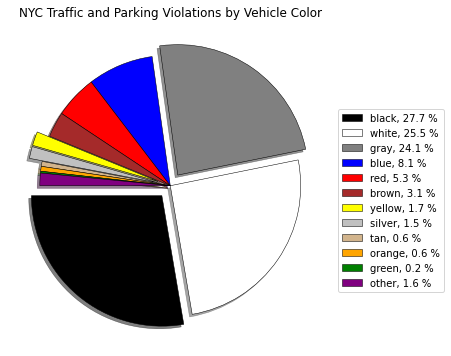

In [11]:
traffic_explode=[0.1,0,0.1,0,0,0,0.1,0.1,0,0,0,0]

pie_plots(color_df['Num Cars Traffic'], color_df['Colors'], traffic_explode)
plt.title('NYC Traffic and Parking Violations by Vehicle Color')
plt.savefig('Output/observed_tickets_by_color.png', dpi=100)
plt.show()

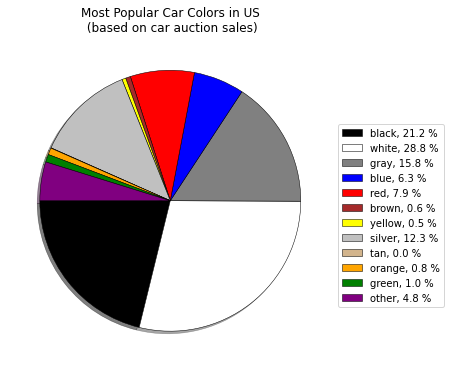

In [12]:
auction_explode = [0,0,0,0,0,0,0,0,0,0,0,0]
pie_plots(color_df['Num Cars Auction'], color_df['Colors'], auction_explode)
plt.title('Most Popular Car Colors in US\n (based on car auction sales)')
plt.savefig('Output/predicted_tickets_by_color.png')
plt.show()

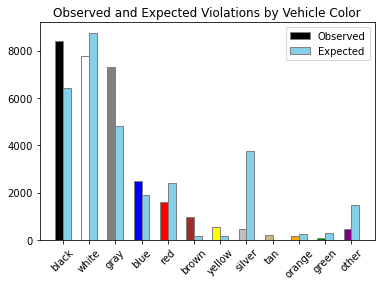

In [13]:
# Defines plot locations
observed_range = np.arange(len(color_df['Colors']))
expected_range = [x + 0.3 for x in observed_range]

# Creates plots
plt.bar(observed_range, color_df['Num Cars Traffic'], 
        width=0.3, label='Observed',
        color=[c if c!='other' else 'purple' for c in color_df['Colors']],
        edgecolor='gray')
plt.bar(expected_range, color_df['Expected'],
        width=0.3, label='Expected',
        color='skyblue', edgecolor='gray')

plt.xticks([r + 0.15 for r in range(len(color_df['Colors']))], color_df['Colors'], rotation=45)
plt.legend()
plt.title('Observed and Expected Violations by Vehicle Color')
plt.savefig('Output/expected_observed_overlay.png')
plt.show()

# Analysis

In [14]:
# Determines statistical significance (if any) of observed vs. expected violations

critical_value = stats.chi2.ppf(q = 0.95, df = len(color_df['Colors'])-1)
p_value = 0.05

print(f'the critical value is {critical_value}.')
print(stats.chisquare(color_df['Num Cars Traffic'], color_df['Expected']))
if (stats.chisquare(color_df['Num Cars Traffic'], color_df['Expected'])[0] > critical_value)&(stats.chisquare(color_df['Num Cars Traffic'], color_df['Expected'])[1]<p_value):
    print('**There is a statistically significant difference between expected and observed violations per color.**')
    
else:
    print('There is no statistically significant difference between expected and observed violations per color.')


the critical value is 19.67513757268249.
Power_divergenceResult(statistic=13001.448038850338, pvalue=0.0)
**There is a statistically significant difference between expected and observed violations per color.**
